# Data Analyst - Getaround Case Study

## Author: `Lauro Cesar Ribeiro`

### Introduction

When using **Getaround**, drivers book cars for a specific time period, from `an hour to a few days
long`. They are supposed to bring back the car on time, but it happens from time to time that
**drivers are late for the checkout**.

Late returns at checkout can generate `high friction for the next driver` if the car was supposed
to be rented again on the same day : Customer service often reports users unsatisfied
because they `had to wait for the car to come back from the previous rental` or users that even
had to `cancel their rental because the car wasn’t returned on time`.

In order to mitigate those issues the task is to **implement a minimum delay between two
rentals**. A car `won’t be displayed in the search results`if the requested `checkin or checkout times are too close` from an already booked rental.

The **Product Manager** still needs to decide:
-  the **threshold**: how long should the `minimum delay` be?
- the **scope**: should we enable the feature `for all cars`?, only `Connect cars`?


# Table of Contents
1. [Importing dependencies](#p1)
2. [Import Dataset](#p2)
3. [Data Manipulation](#p3)
4. [Exploratory Data Analysis](#p4)
5. [Hypothesis Testing](#p5)
   * [How many rentals would be affected by the feature depending on the threshold and scope chosen?](#p5-1)
   * [What is relation between delayed check-outs and the next rental remaining time?](#p5-2)
   * [How many problematic cases will it solve depending on the threshold and the scope?](#p5-3)
6. [Conclusion](#p6)

# <a name="p1">Importing Dependencies</a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_palette(sns.color_palette())

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

# <a name="p2">Import Dataset</a>

**rental_id**:	Unique identifier of the rental

**car_id**	Unique identifier of the car

**checkin_type**	"Flow used for both checkin and checkout. (ie. access and return the car)
- mobile = rental agreement signed on the owner's smartphone
- connect = car equiped with the Connect technology , opened by the driver with his smartphone.

*Note: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case"
state	canceled means that the rental did not happen (was canceled by the driver or the owner).*

**delay_at_checkout_in_minutes**	Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
previous_ended_rental_id	id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)

**time_delta_with_previous_rental_in_minutes**	Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)

In [2]:
test = pd.read_excel("casestudy.xlsx")

test.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,Unnamed: 7,Unnamed: 8
0,505000,363965,mobile,canceled,NaN,NaN,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN,NaN,NaN


In [3]:
# Delete Unecessary columns 
    
test = test.drop(columns = ['Unnamed: 7', 'Unnamed: 8'])

# <a name="p3">Data Manipulation</a>

Because the dataset has many Null values indicating either rentals checkouts over 12 hours afterwards or no renting at all, it might overlap with the next check-in, causing problems. For this reason, we will work separately with the dataframe by creating other variables. 

In [4]:
# Copy the original dataframe to a new variable named getaround for further analysis.

getaround = test.copy()

In [5]:
# Information about dataset 

getaround.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


The dataframe has **21310 entries** and **7 columns**, note the 3 last columns, `"delay_at_checkout_in_minutes"`,`"previous_ended_rental_id"`, `"time_delta_with_previous_rental_in_minutes"` have many null values.

In [6]:
# Checking out null values in all columns and as expected there are lots.

getaround.isna().sum()

rental_id                                         0
car_id                                            0
checkin_type                                      0
state                                             0
delay_at_checkout_in_minutes                   4964
previous_ended_rental_id                      19469
time_delta_with_previous_rental_in_minutes    19469
dtype: int64

In [7]:
# Fill Null float values with 0

getaround = getaround.fillna(0)

Most of **missing data** are null values from `numeric` columns, the reason we replaced them with **0.**

# <a name="p4">Exploratory Data Analysis</a>

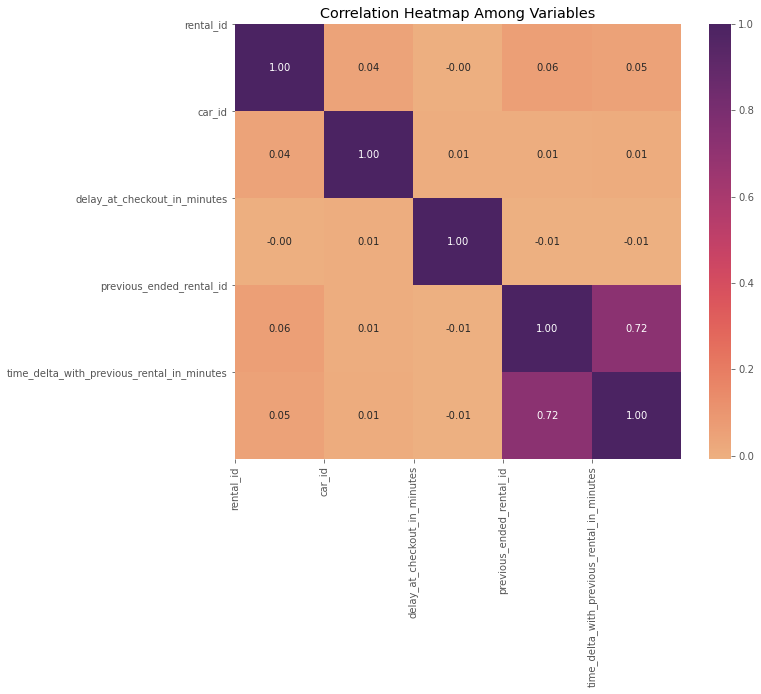

In [8]:
# Create a Heatmap

corr = getaround.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='flare', annot=True, fmt=".2f").set_title("Correlation Heatmap Among Variables")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

Apart from `previous_ended_rental_id` and `time_delta_with_previous_rental_in_minutes` that has **72% correlation** each other, the other columns are not correlated.

# Check-in Type Analysis

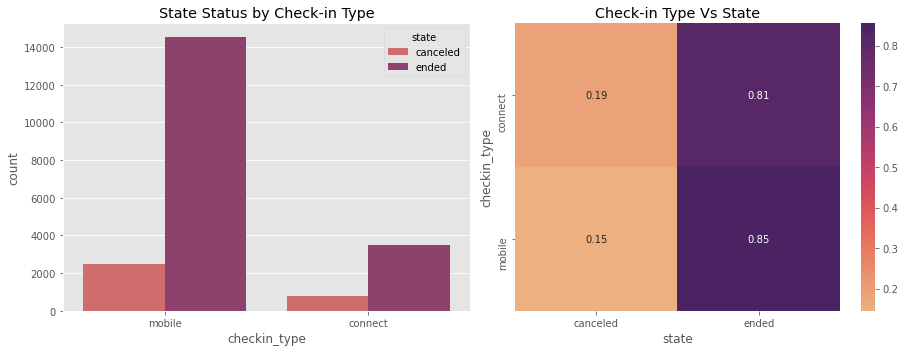

checkin_type  state   
mobile        ended       14536
connect       ended        3509
mobile        canceled     2467
connect       canceled      798
Name: state, dtype: int64

In [9]:
# Create a grouped Barplot
plt.figure(figsize=(13,5))
plt.subplot(121)
sns.countplot(x='checkin_type', data= getaround, hue='state', palette='flare').set_title("State Status by Check-in Type")

# Create a Heatmap Matrix
plt.subplot(122)
sns.heatmap(pd.crosstab(getaround['checkin_type'], getaround['state'],normalize='index'),cmap="flare", annot=True)
plt.title('Check-in Type Vs State')

plt.tight_layout()
plt.show()

getaround.groupby('checkin_type')['state'].value_counts().sort_values(ascending=False)

Most customers prefer the **Mobile App** instead of the Connect one, we raised `4 hypotheses` for that:
- Customers rather see the car before renting it. 
- Customers trust more in the app due to the agreement bewteen them and the car`s owner.
- Customers are not familiar with Connect.
- Customers do not trust whether the car will be ready on time or not.

# Canceled Rentals Analysis

In [10]:
# Sliced the Cancelled Transactions 

canceled = getaround[getaround['state']=='canceled']

canceled[['delay_at_checkout_in_minutes','time_delta_with_previous_rental_in_minutes']].describe()

,delay_at_checkout_in_minutes,time_delta_with_previous_rental_in_minutes
count,3265.000000,3265.000000
mean,-5.350077,20.683002
std,305.704330,100.297928
min,-17468.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.000000,720.000000


We sliced the `cancelled transactions` to apply statistical analysis on them, where we found out the `average check-out delay` is **5 minutes in advance** and the `average next rental` is **20 minutes after this cancelling**.

My Hypotheses are: 
- Customers changed their minds on renting.
- Customers are on rush hours so, they do not want to be stuck in the traffic, we assume this because the average next rental is 20 minutes afterwards.

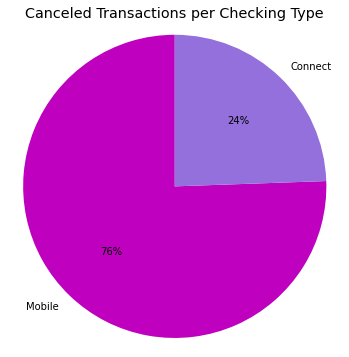

mobile     2467
connect     798
Name: checkin_type, dtype: int64

In [11]:
# Create a Pie Chart with percentage

label = 'Mobile','Connect' 
data = [getaround[(getaround.checkin_type=='mobile') & (getaround.state=='canceled')]['checkin_type'].count(),getaround[(getaround.checkin_type=='connect') & (getaround.state=='canceled')]['checkin_type'].count() ]
col =('m','mediumpurple')
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(data , labels=label, autopct='%1.f%%', startangle=90,colors=col)
ax.axis('equal')

plt.title('Canceled Transactions per Checking Type')
plt.show()


getaround[getaround.state == 'canceled'].checkin_type.value_counts()

Almost **1/4** of all `Cancelled transactions` come from the **Connect**, although it is not much popular, it shows a significant cancelling percentage. **76%** of Cancelled transactions are from **Mobile App** users.

Hypotheses:
- Check-out delays that do not leave the car ready for the next rental.
- Car appears available to customers on the app but, they have not been checked-out yet.

## Ended Rentals Analysis

In [12]:
# sliced the data to apply statistical analysis on the Ended Transactions

ended = getaround[getaround['state'] == 'ended']
ended

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
1,507750,269550,mobile,ended,-81.0,0.0,0.0
2,508131,359049,connect,ended,70.0,0.0,0.0
4,511440,313932,mobile,ended,0.0,0.0,0.0
5,511626,398802,mobile,ended,-203.0,0.0,0.0
6,511639,370585,connect,ended,-15.0,563782.0,570.0
...,...,...,...,...,...,...,...
21305,573446,380069,mobile,ended,0.0,573429.0,300.0
21306,573790,341965,mobile,ended,-337.0,0.0,0.0
21307,573791,364890,mobile,ended,144.0,0.0,0.0
21308,574852,362531,connect,ended,-76.0,0.0,0.0


In [13]:
# Applied Statistical Analysis 

ended[['delay_at_checkout_in_minutes', 'time_delta_with_previous_rental_in_minutes']].describe()

,delay_at_checkout_in_minutes,time_delta_with_previous_rental_in_minutes
count,18045.000000,18045.000000
mean,55.048434,24.751455
std,945.397306,109.810555
min,-22433.000000,0.000000
25%,-28.000000,0.000000
50%,3.000000,0.000000
75%,57.000000,0.000000
max,71084.000000,720.000000


The average Check-out delay is `55 minutes late`, there is an unlikely value for the minimum as `-22433`, which is an outlier. **25%** of Ended Transactions check-out `28 minutes in advance`, **50%** check-out `3 minutes late` and **75%** check-out `57 minutes late.`

The average time gap to the `next rental is 24 minutes.`



# <a name="p5">Hypothesis Testing</a>

In [14]:
# Created a function to call back on my testings.

from scipy import stats

def t_test(a,b):
    _, p_value = stats.ttest_ind(a.values,b=b.values,equal_var=True)
    if(p_value<0.05):
        print('"\033[1m" We accept alternate hypothesis that there is a statistical difference')
    else:
        print('We accept null hypothesis that there is no statistical difference')
    
    print('P value is ', p_value)

**Does the average checkout delay influence successful Ended Transactions for Mobile and Connect users?**

In [15]:
a = getaround[(getaround.state=='ended')&(getaround.checkin_type=='mobile')].groupby('rental_id').delay_at_checkout_in_minutes.mean()
b = getaround[(getaround.state=='ended')&(getaround.checkin_type=='connect')].groupby('rental_id').delay_at_checkout_in_minutes.mean()
print("This is the shape: ", a.shape[0],b.shape[0])
t_test(a,b)

This is the shape:  14536 3509
"" We accept alternate hypothesis that there is a statistical difference
P value is  1.0462016309237e-11


**Yes**, Checkout delays influence ended transactions for Mobile and Connect users, we believe for the renting to happen the car has to be enable for rental, it seems obvious but if all customers delay at the same time, Getaround would struggle with revenues.

**Does the average checkout delay influence cancelled Transactions for Mobile and Connect users?**

In [16]:
a = getaround[(getaround.state=='canceled')&(getaround.checkin_type=='mobile')].groupby('rental_id').delay_at_checkout_in_minutes.mean()
b = getaround[(getaround.state=='canceled')&(getaround.checkin_type=='connect')].groupby('rental_id').delay_at_checkout_in_minutes.mean()
print("This is the shape: ", a.shape[0],b.shape[0])
t_test(a,b)

This is the shape:  2467 798
We accept null hypothesis that there is no statistical difference
P value is  0.5696089938303379


**No**, delayed checkouts do not influence on customer`s decisions to cancel the renting based on the two check-in types analysed, there would have other reasons for that, we believe customers may find the car uncomfortable, or not fully fueled, or dirty from the previous rental, or they have found a quicker way to reach their destination.

**Does the average time gap between previous and next rental influence ended transactions for Mobile and Connect users?**

In [17]:
a = getaround[(getaround.state=='ended')&(getaround.checkin_type=='mobile')].groupby('rental_id').time_delta_with_previous_rental_in_minutes.mean()
b = getaround[(getaround.state=='ended')&(getaround.checkin_type=='connect')].groupby('rental_id').time_delta_with_previous_rental_in_minutes.mean()
print("This is the shape: ", a.shape[0],b.shape[0])
t_test(a,b)

This is the shape:  14536 3509
"" We accept alternate hypothesis that there is a statistical difference
P value is  9.958706234841174e-77


**Yes**, there is a massive statistical probability of the previous and next rental time gap to influence on ended transactions for both check-in types. The main reason is the waiting for the car availability, `this is the biggest issue found`.

**Does the average time gap between previous and next rental influence cancelled transactions for Mobile and Connect users?**

In [18]:
a = getaround[(getaround.state=='canceled')&(getaround.checkin_type=='mobile')].groupby('rental_id').time_delta_with_previous_rental_in_minutes.mean()
b = getaround[(getaround.state=='canceled')&(getaround.checkin_type=='connect')].groupby('rental_id').time_delta_with_previous_rental_in_minutes.mean()
print("This is the shape: ", a.shape[0],b.shape[0])
t_test(a,b)

This is the shape:  2467 798
"" We accept alternate hypothesis that there is a statistical difference
P value is  1.2192368116622203e-20


**Yes**, consequently cancellings might happen if the car appears available in the app or parked for Connect users but it is actually not. This is a big issue to Customer Lifetime Value, Churn, Company`s brand identity and Revenue.

# Check-out Analysis

It seems almost all problems are caused by the Check-out Delays that affect the next rental.

Text(0.5, 1.0, 'Checkout Delays')

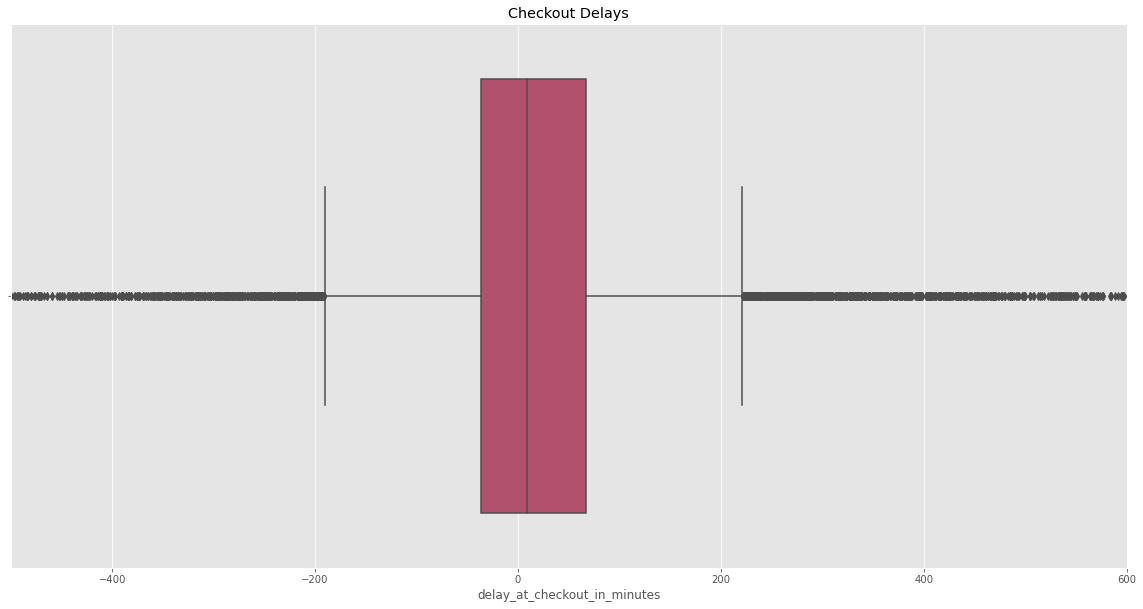

In [19]:
# Create a Boxplot to analyse outliers

fig, ax = plt.subplots(figsize=(20, 10))
plt.xlim(-500, 600)
sns.boxplot(test['delay_at_checkout_in_minutes'], ax=ax, palette='flare').set_title("Checkout Delays")

The boxplot shows a range that varies from **approximately** `150 minutes checkouts in advance till 190 minutes late checkouts`. Anything higher is an outlier, and this data has many.

(-300.0, 700.0)

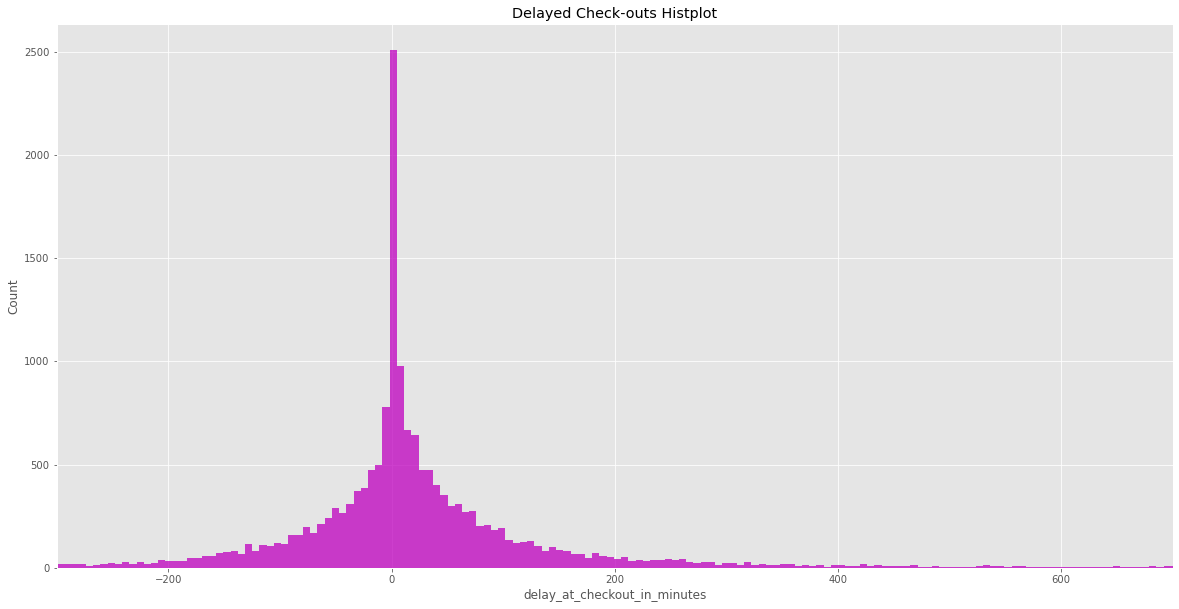

In [20]:
# Create a Histplot to analyze data distribution 

fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(data=test, x=ended['delay_at_checkout_in_minutes'], color='m').set_title("Delayed Check-outs Histplot")
plt.xlim(-300, 700)

The histplot shows the curve `starts to flatten at 200 minutes late`, there is a good sign regards the deadline to display rented cars,to make them available for next rentals on the app.

In [21]:
# Apply statistical Analysis on late checkouts

late_checkout = test[test['delay_at_checkout_in_minutes']>0]

late_checkout[['delay_at_checkout_in_minutes','time_delta_with_previous_rental_in_minutes']].describe()

,delay_at_checkout_in_minutes,time_delta_with_previous_rental_in_minutes
count,9404.000000,802.000000
mean,201.791472,259.376559
std,1243.645804,248.481753
min,1.000000,0.000000
25%,19.000000,60.000000
50%,53.000000,150.000000
75%,131.000000,480.000000
max,71084.000000,720.000000


As the graphs had shown, the average checkout delay is **201 minutes**, that responds the **"how long should the minimum delay be?"** question.

An interesting fact is the `next rental` starts `22 minutes` after delayed checkouts in average.

In [22]:
# Apply statistical Analysis for Customers who checked out at the exact time.

exact_checkout = ended[ended['delay_at_checkout_in_minutes'] == 0]

exact_checkout[['delay_at_checkout_in_minutes','time_delta_with_previous_rental_in_minutes']].describe()

,delay_at_checkout_in_minutes,time_delta_with_previous_rental_in_minutes
count,1822.0,1822.000000
mean,0.0,16.416026
std,0.0,89.902310
min,0.0,0.000000
25%,0.0,0.000000
50%,0.0,0.000000
75%,0.0,0.000000
max,0.0,720.000000


The most interesting thing here is the next rental starts `16 minutes` in average after the correct checkout time. It is the lowest value so far, that would increase company`s revenue because the high searching.

In [23]:
# Apply statistical analysis for early checkouts 

early_checkout = ended[ended['delay_at_checkout_in_minutes']<0]

early_checkout[['delay_at_checkout_in_minutes','time_delta_with_previous_rental_in_minutes']].describe()

,delay_at_checkout_in_minutes,time_delta_with_previous_rental_in_minutes
count,6819.000000,6819.000000
mean,-132.614460,30.607127
std,408.175795,123.284406
min,-22433.000000,0.000000
25%,-120.000000,0.000000
50%,-52.000000,0.000000
75%,-19.000000,0.000000
max,-1.000000,720.000000


Early check-outs happen in average `132 minutes` in advance, and the next rental average in `30 minutes` after. We raised hypotheses that those customers face car issues on renting because we have the longest next rental average in analysis.

Number of Late Checkouts:  9404
Number of Early Checkouts:  6819
Number of Exact Checkouts:  1822


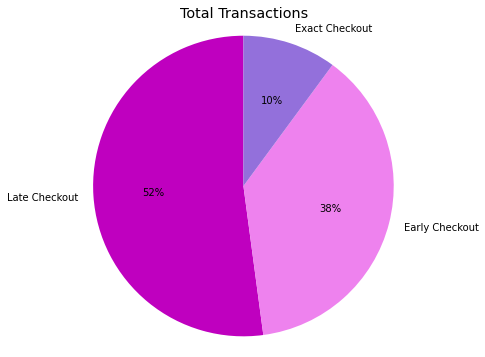

In [24]:
print("Number of Late Checkouts: ", len(late_checkout))
print("Number of Early Checkouts: ", len(early_checkout))
print("Number of Exact Checkouts: ", len(exact_checkout))

label = 'Late Checkout','Early Checkout', 'Exact Checkout'
data = [len(late_checkout),len(early_checkout), len(exact_checkout)]
col =('m','violet', 'mediumpurple')
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(data , labels=label, autopct='%1.f%%', startangle=90,colors=col)
ax.axis('equal')

plt.title('Total Transactions')
plt.show()


Late check-outs take `52%` of all available cars, `more than the half`. That may risk next rentals to happen and requires a watch-out.

We will analyse Delayed Checkouts within 200 minutes range to find which check-in type they use, to raise hypotheses.

In [25]:
# Filtering Delayed Check-outs.

below_200_minutes = ended[ended['delay_at_checkout_in_minutes']<200]

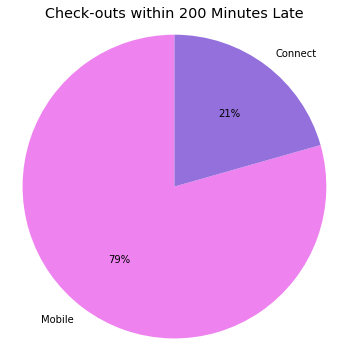

mobile     13069
connect     3389
Name: checkin_type, dtype: int64

In [26]:
# Create a Pie chart of checkin types from filtered delayed check-outs

label = 'Mobile', 'Connect'
data = [below_200_minutes[(below_200_minutes.checkin_type=='mobile')]['checkin_type'].count(),below_200_minutes[(below_200_minutes.checkin_type=='connect')]['checkin_type'].count() ]
col =('violet', 'mediumpurple')
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(data , labels=label, autopct='%1.f%%', startangle=90,colors=col)
ax.axis('equal')

plt.title('Check-outs within 200 Minutes Late')
plt.show()

below_200_minutes.checkin_type.value_counts()

**79%** comes from Mobile users and **21%** from Connect, initially, it seems the scope should be applied only to Mobile users but, considering Connect as not so popular, 21% is a significant amount corresponding to `4187` late check-outs.

# Next Rental Overlaping Analysis

The `time_delta_with_previous_rental_in_minutes` column holds the difference in minutes between last rental check-out and the next check-in, when lower than 12 hours, and Null if higher.

It can be problematic if the check-out delay overlaps the next check-in, for this reason we created a df dataframe to analyse this issue, there will have an extra `time_between_next_checkin` column, which holds the minutes between last and next rental, all other fields will be filled with Null values.

In [27]:
df = pd.DataFrame(columns = ['rental_id','car_id','checkin_type','state','delay_at_checkout_in_minutes','previous_ended_rental_id','time_delta_with_previous_rental_in_minutes', 'time_between_next_checkin'])

for value in test.previous_ended_rental_id[:(len(test))]:
    if np.isnan(value) == False:
        df = df.append(test.loc[test.rental_id == value]).append({'time_between_next_checkin': test.time_delta_with_previous_rental_in_minutes[test.previous_ended_rental_id.tolist().index(value)]}, ignore_index=True)
        
df.sort_index(inplace=True)

df


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,time_between_next_checkin
0,563782,370585,connect,ended,136.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,570.0
2,545639,312389,mobile,ended,140.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420.0
4,537298,392479,mobile,ended,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.0
3678,545045,377312,mobile,ended,22.0,563963.0,630.0,NaN
3679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0
3680,573429,380069,mobile,ended,NaN,562010.0,30.0,NaN


In [28]:
# Remove those extras Null Values and Chunk them on the same row.

for i in range(len(df.time_between_next_checkin)):
    value = df.time_between_next_checkin[i]
    if np.isnan(value) == True:
        df.time_between_next_checkin[i] = df.time_between_next_checkin[i+1]



df.drop(range(1, len(df), 2), inplace=True)

In [29]:
# Correct the dataframe Index

df = df.set_index([pd.Index(range(len(df)))])
df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,time_between_next_checkin
0,563782,370585,connect,ended,136.0,NaN,NaN,570.0
1,545639,312389,mobile,ended,140.0,NaN,NaN,420.0
2,537298,392479,mobile,ended,NaN,NaN,NaN,0.0
3,510607,349751,mobile,ended,-113.0,NaN,NaN,60.0
4,557404,181625,connect,ended,-352.0,554077.0,120.0,330.0


In [30]:
# Replace the delay_at_checkout_in_minutes null values with 0

df['delay_at_checkout_in_minutes'] = df['delay_at_checkout_in_minutes'].fillna(0)

### <a name="p5-1">How many rentals would be affected by the feature depending on the threshold and scope chosen?</a>

We can affirm that Affected rentals would be the ones that have a delay with previous rentals lower than the threshold set.

In [31]:
# Extract the Connect and Mobile checkin_type length

data = test[test['state'] == 'ended']

total_connect = len(data[data['checkin_type'] == 'connect'])
total_mobile = len(data[data['checkin_type'] == 'mobile'])

print("The Connect length is: ", total_connect)
print("The Mobile length is: ", total_mobile)

The Connect length is:  3509
The Mobile length is:  14536


In [32]:
# Remove null values from 'time_delta_with_previous_rental_in_minutes' and filter values below the threshold
# Return the affected rentals over total values percentage

def affected_rentals(threshold):
    affected = data[['time_delta_with_previous_rental_in_minutes']].dropna()
    affected = affected[affected['time_delta_with_previous_rental_in_minutes'] < threshold]
    return len(affected)/len(data)

# Filter Connect users values, Remove Null values from 'time_delta_with_previous_rental_in_minutes', and filter values below the threshold
# Return the affected rentals over the total connect values percentage

def connect_checkout_time(threshold):
    affected_rental = data[data['checkin_type'] == 'connect']
    affected_rental = affected_rental[['time_delta_with_previous_rental_in_minutes']].dropna()
    affected_rental = affected_rental[affected_rental['time_delta_with_previous_rental_in_minutes'] < threshold]
    return len(affected_rental)/total_connect

# Filter Mobile users values, Remove Null values from 'time_delta_with_previous_rental_in_minutes', and filter values below the threshold
# Return the affected rentals over the total mobile values percentage

def mobile_checkout_time(threshold):
    affected_rental = data[data['checkin_type'] == 'mobile'] 
    affected_rental = affected_rental[['time_delta_with_previous_rental_in_minutes']].dropna()
    affected_rental = affected_rental[affected_rental['time_delta_with_previous_rental_in_minutes'] < threshold]
    return len(affected_rental)/total_mobile

In [33]:
# Create a x_list from 0 till 799 minutes
x_list = np.arange(0,800,1)

# Create an empty list
y_list_all = []

# For each value from the "x_list" passes into 'affected_rentals' functions and append the result to "y_list_all"
for x in x_list:
    y_list_all.append(affected_rentals(x))

# Create an empty List
y_list_connect = []

# For each value from the "x_list" passes into 'connect_checkout_time' functions and append the result to "y_list_connect"
for x in x_list:
    y_list_connect.append(connect_checkout_time(x))

# Create an empty list
y_list_mobile = []

# For each value from the "x_list" passes into 'mobile_checkout_time' functions and append the result to "y_list_mobile"
for x in x_list:
    y_list_mobile.append(mobile_checkout_time(x))


(0.0, 0.3)

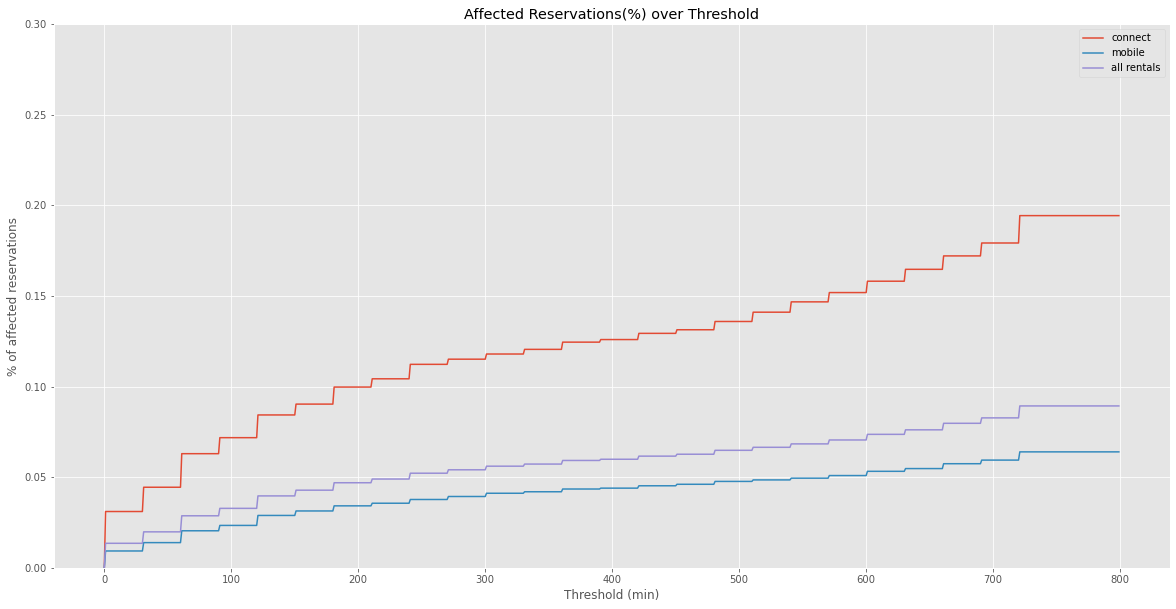

In [34]:
# Plot a Line chart of Threshold analysis

ax = fig.add_subplot(1, 1, 1)
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(x_list, y_list_connect)
ax.plot(x_list, y_list_mobile)
ax.plot(x_list, y_list_all)

ax.set_title("Affected Reservations(%) over Threshold")
ax.set_xlabel('Threshold (min)')
ax.set_ylabel('% of affected reservations')
labels = [ 'connect', 'mobile', 'all rentals']
ax.legend(labels)
plt.ylim(0, 0.3)



**Connect users** are the most affected with `~18%` of all dataset; the reason could be the fact that they do not need to check the car availability on the app or meet the owner`s to sign a contract to get the keys.

It **does not affect much** on `Mobile users` because we strongly believe they have to check in advance. 

### <a name="p5-2">What is relation between delayed check-outs and the next rental remaining time?</a>

Based on the previous analysis, we raised this question because this time gap has an impact on future rentings.

In [35]:
# Create a 'checkout_checkin_difference' columns from the difference between 'time_between_next_checkin' and 'delay_at_checkout_in_minutes'

df['checkout_checkin_difference'] = df['time_between_next_checkin'] - df['delay_at_checkout_in_minutes']
df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,time_between_next_checkin,checkout_checkin_difference
0,563782,370585,connect,ended,136.0,NaN,NaN,570.0,434.0
1,545639,312389,mobile,ended,140.0,NaN,NaN,420.0,280.0
2,537298,392479,mobile,ended,0.0,NaN,NaN,0.0,0.0
3,510607,349751,mobile,ended,-113.0,NaN,NaN,60.0,173.0
4,557404,181625,connect,ended,-352.0,554077.0,120.0,330.0,682.0


# Problematic Cases Analysis

It seems strange how often customers check out in advance; there is much to explore in understanding the reasons why, it would help them to rent more, and have a great user experience from us. Because we believe they are clearly unsatisfied.

In [36]:
# values from customers who checked-out in advance 

df[df['checkout_checkin_difference'] < 0].head(15)

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,time_between_next_checkin,checkout_checkin_difference
11,539751,374684,mobile,ended,3.0,537514.0,660.0,0.0,-3.0
12,540607,382364,mobile,ended,1.0,NaN,NaN,0.0,-1.0
37,540868,408776,mobile,ended,26.0,NaN,NaN,0.0,-26.0
64,572909,301512,mobile,ended,13.0,NaN,NaN,0.0,-13.0
68,533413,353425,connect,ended,4.0,NaN,NaN,0.0,-4.0
69,541519,408821,mobile,ended,95.0,NaN,NaN,90.0,-5.0
88,536978,378931,mobile,ended,271.0,NaN,NaN,60.0,-211.0
93,514474,376574,mobile,ended,81.0,NaN,NaN,0.0,-81.0
122,548646,282893,mobile,ended,201.0,NaN,NaN,30.0,-171.0
128,548169,375834,mobile,ended,5.0,NaN,NaN,0.0,-5.0


In [37]:
# Customer who checked-out in advance are problematic cases.

problematic_cases = len(df[df['checkout_checkin_difference'] < 0])
print("This is the number of Problematic Cases: ", problematic_cases)

This is the number of Problematic Cases:  219


In [38]:
problematic_cases_percentage = problematic_cases / len(ended)
print("This is the Problematic Cases Percetage for Ended Transactions: ", round(problematic_cases_percentage * 100, 1),"%")

This is the Problematic Cases Percetage for Ended Transactions:  1.2 %


In [39]:
# Problematic Cases Check-in Types: Mobile Users have more than the double of Connect users.

df[df['checkout_checkin_difference'] < 0].checkin_type.value_counts()

mobile     148
connect     71
Name: checkin_type, dtype: int64

### <a name="p5-3">How many problematic cases will it solve depending on the threshold and the scope?</a>

We will apply the same technique but instead of using the whole dataset and the "time_delta_with_previous_rental_in_minutes" column, we will work with **problematic cases** and **"checkout_checkin_difference"** column.

In [40]:
# Filter problematic cases 

df[df['checkout_checkin_difference'] < 0]

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,time_between_next_checkin,checkout_checkin_difference
11,539751,374684,mobile,ended,3.0,537514.0,660.0,0.0,-3.0
12,540607,382364,mobile,ended,1.0,NaN,NaN,0.0,-1.0
37,540868,408776,mobile,ended,26.0,NaN,NaN,0.0,-26.0
64,572909,301512,mobile,ended,13.0,NaN,NaN,0.0,-13.0
68,533413,353425,connect,ended,4.0,NaN,NaN,0.0,-4.0
...,...,...,...,...,...,...,...,...,...
1806,550186,410402,mobile,ended,21.0,NaN,NaN,0.0,-21.0
1812,534678,383344,connect,ended,164.0,563620.0,240.0,60.0,-104.0
1823,564756,378689,mobile,ended,39.0,NaN,NaN,0.0,-39.0
1835,567708,294059,mobile,ended,283.0,NaN,NaN,120.0,-163.0


In [41]:
# Assign problematic cases to 'cases_to_solve' variable

cases_to_solve = df[df['checkout_checkin_difference'] < 0]
print("Number of Cases to Solve: ", len(cases_to_solve))

Number of Cases to Solve:  219


In [42]:
connect_solved = df[df['checkout_checkin_difference'] < 0]
connect_solved = connect_solved[connect_solved['checkin_type'] == 'connect']
connect_solved = len(connect_solved)
print("Number of Cases to Solve using Connect: ", connect_solved)

Number of Cases to Solve using Connect:  71


In [43]:
mobile_solved = df[df['checkout_checkin_difference'] < 0]
mobile_solved  = mobile_solved [mobile_solved ['checkin_type'] == 'mobile']
mobile_solved  = len(mobile_solved )
print("Number of Cases to Solve using Mobile: ", mobile_solved )

Number of Cases to Solve using Mobile:  148


In [44]:
# Filter Problematic Cases, filter 'delay_at_checkout_in_minutes' lower than threshold, 
# Return the percentage of cases to solve and problematic cases.

def cases_solved(threshold):
    cases_to_solve = df[df['checkout_checkin_difference'] < 0]
    cases_to_solve = cases_to_solve[cases_to_solve['delay_at_checkout_in_minutes'] < threshold]
    return len(cases_to_solve)/problematic_cases

# Filter Problematic Cases, filter 'checkin_type' equals to Connect, filter 'delay_at_checkout_in_minutes' lower than threshold, 
# Return the percentage of cases to solve over the number of Connect transactions.

def cases_solved_connect(threshold):
    cases_to_solve = df[df['checkout_checkin_difference'] < 0]
    cases_to_solve = cases_to_solve[cases_to_solve['checkin_type'] == 'connect']
    cases_to_solve = cases_to_solve[cases_to_solve['delay_at_checkout_in_minutes'] < threshold]
    return len(cases_to_solve)/connect_solved

# Filter Problematic Cases, filter 'checkin_type' equals to Mobile, filter 'delay_at_checkout_in_minutes' lower than threshold, 
# Return the percentage of cases to solve over the number of Mobile transactions.

def cases_solved_mobile(threshold):
    cases_to_solve = df[df['checkout_checkin_difference'] < 0]
    cases_to_solve = cases_to_solve[cases_to_solve['checkin_type'] == 'mobile']
    cases_to_solve = cases_to_solve[cases_to_solve['delay_at_checkout_in_minutes'] < threshold]
    return len(cases_to_solve)/mobile_solved 

In [45]:
# Create a x_list from 0 till 799 minutes
x_list_solved = np.arange(0,800,1)

# Create an empty list
y_list_solved = []

# For each value from the "x_list_solved" passes into 'cases_solved' function and append the result to "y_list_solved"
for x in x_list_solved:
    y_list_solved.append(cases_solved(x))
    
# Create an empty list
y_list_solved_connect = []

# For each value from the "x_list_solved" passes into 'cases_solved_connect' function and append the result to "y_list_solved_connect"
for x in x_list_solved:
    y_list_solved_connect.append(cases_solved_connect(x))
    
# Create an empty list
y_list_solved_mobile = []

# For each value from the "x_list_solved" passes into 'cases_solved_mobile' function and append the result to "y_list_solved_mobile"
for x in x_list_solved:
    y_list_solved_mobile.append(cases_solved_mobile(x))

(0.0, 1.2)

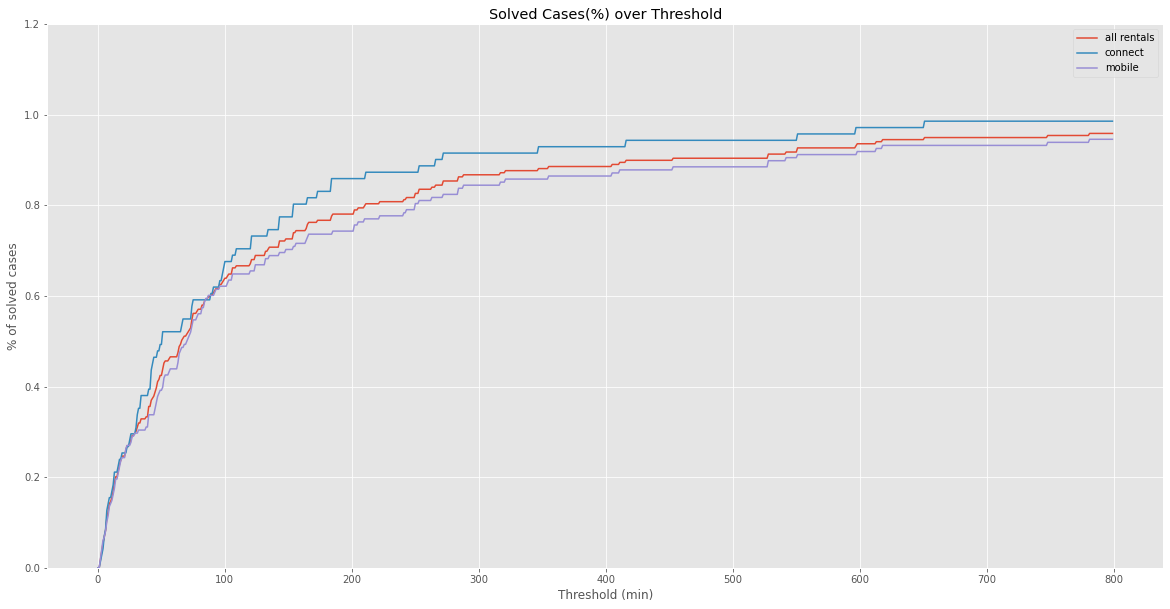

In [46]:
# Plot a Line chart of Threshold analysis

ax = fig.add_subplot(1, 1, 1)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x_list_solved, y_list_solved)
ax.plot(x_list_solved, y_list_solved_connect)
ax.plot(x_list_solved, y_list_solved_mobile)

labels = ['all rentals', 'connect', 'mobile']
ax.legend(labels)
ax.set_title("Solved Cases(%) over Threshold")
ax.set_xlabel('Threshold (min)')
ax.set_ylabel('% of solved cases')
plt.ylim(0, 1.2)

We extracted cases where the `checkout delay` of **X** was higher than the delay with previous of **Y**, we can name 'Y' as `problematics`. We analysed the `percentage` of **solved cases**, where `threshold` is **greater than delay at checkout**, depending on the `threshold` and the `scope`. 

We can see that `mobile`, `connect` and `all rental` behave similarly.

# <a name="p6">Conclusion</a>

**how long should the minimum delay be?** 

Based on Statistical Analysis the minimum delay is 200 minutes.

**Should we enable the feature for all cars? Only Connect cars?**

The feature performs best on Mobile although they all behave quite similar, my recommendation is to extend it to **all cars** for better results.




